<a href="https://colab.research.google.com/github/Aniket7773/CreditCardFraud/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/Colab Notebooks/german_credit_data.csv'
df = pd.read_csv(data_path, encoding='ascii', delimiter=',')

if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

# Converting relevant columns to categorical for having a better
# understanding
categorical_columns = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')



--- Data Overview ---
   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  
0         6             radio/TV  
1        48             radio/TV  
2        12            education  
3        42  furniture/equipment  
4        24                  car  

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               1000 non-null   int64   
 1   Sex               1000 n

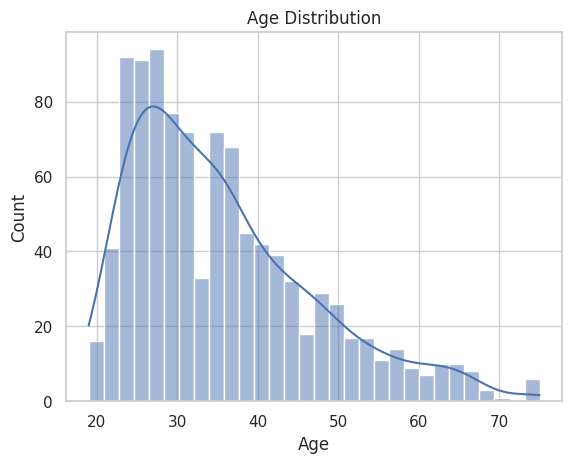

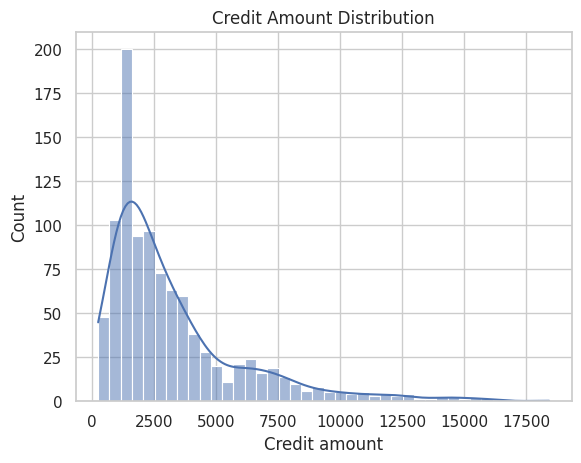

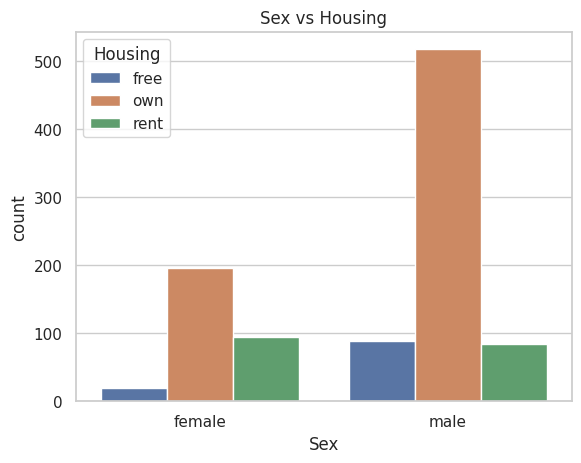

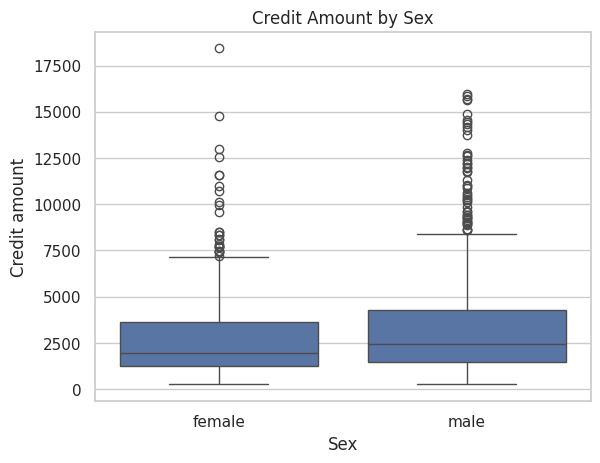

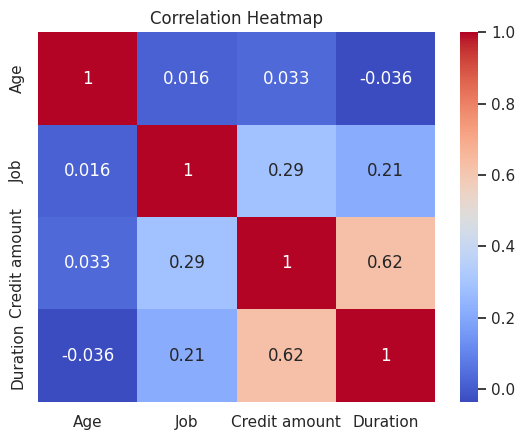

In [4]:
print('\n--- Data Overview ---')
print(df.head())

print('\n--- Info ---')
print(df.info())

print('\n--- Summary Statistics ---')
print(df.describe(include='all'))

print('\n--- Missing Values ---')
print(df.isnull().sum())

sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

sns.histplot(df['Credit amount'], bins=40, kde=True)
plt.title('Credit Amount Distribution')
plt.show()

sns.countplot(data=df, x='Sex', hue='Housing')
plt.title('Sex vs Housing')
plt.show()

sns.boxplot(x='Sex', y='Credit amount', data=df)
plt.title('Credit Amount by Sex')
plt.show()

sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [5]:

# Converting relevant object-type columns to category
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

# Handling missing values present in the dataset
for col in df.columns:
    if df[col].dtype.name == 'category':
        if 'Unknown' not in df[col].cat.categories:
            df[col] = df[col].cat.add_categories('Unknown')
        df[col] = df[col].fillna('Unknown')
    elif df[col].dtype.name in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].median())

# Removing duplicate rows from the dataset
initial_shape = df.shape
df.drop_duplicates(inplace=True)
if df.shape != initial_shape:
    print(f"🧽 Removed {initial_shape[0] - df.shape[0]} duplicate rows.")

# Removing rows with invalid values
df = df[df['Age'] > 0]
df = df[df['Duration'] > 0]
df = df[df['Credit amount'] > 0]

df.reset_index(drop=True, inplace=True)

print("\n✅ Data cleaning completed. Cleaned data preview:")
print(df.head())



✅ Data cleaning completed. Cleaned data preview:
   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own         Unknown           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little          Unknown           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  
0         6             radio/TV  
1        48             radio/TV  
2        12            education  
3        42  furniture/equipment  
4        24                  car  


In [25]:
# Feature Mapping :-  analysis of how monthy credit amount vs duration to detect fraud
median_credit = df['Credit amount'].median()
df['HighCredit'] = (df['Credit amount'] > median_credit).astype(int)

# New Feature: Credit-per-Month
df['Credit_per_Month'] = df['Credit amount'] / df['Duration']
df['Credit_per_Month'].replace([np.inf, -np.inf], 0, inplace=True)
df['Credit_per_Month'] = df['Credit_per_Month'].fillna(0)

df['Age_Group'] = pd.cut(df['Age'], bins=[18, 25, 35, 50, 65, 100], labels=False)

df['Duration_x_Age'] = df['Duration'] * df['Age']

df['Purpose_Count'] = df.groupby('Purpose')['Purpose'].transform('count')

features = features + ['Age_Group', 'Duration_x_Age', 'Purpose_Count','Credit_per_Month']


X = df[features]
y = df['HighCredit']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [7]:
features = ['Age', 'Job', 'Duration', 'Credit_per_Month', 'Sex', 'Housing',
            'Saving accounts', 'Checking account', 'Purpose']
X = df[features]
y = df['HighCredit']

# One-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Spliting into training and testing sets
# the ratio of train : test solit s 70 : 30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

param_dist = {
    'n_estimators': randint(150, 300),
    'max_depth': [None, 6, 7],
    'min_samples_split': randint(3, 10),
    'min_samples_leaf': randint(2, 5)
}

rf = RandomForestClassifier(random_state=42)


random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_
print("Best params:", random_search.best_params_)



Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 164}



XGBoost Prediction Accuracy: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       155
           1       0.94      0.99      0.96       145

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



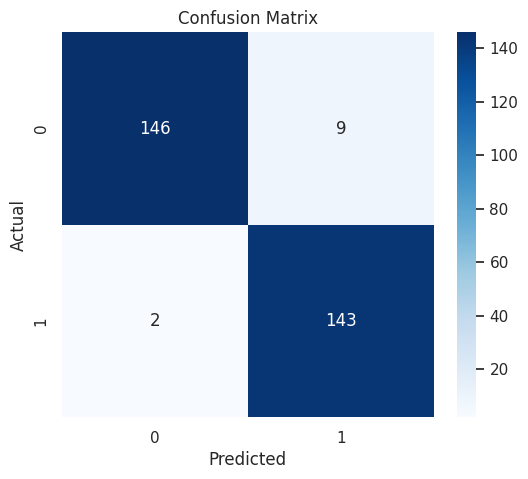

In [28]:
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'\nXGBoost Prediction Accuracy: {accuracy:.2f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Preparing the Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


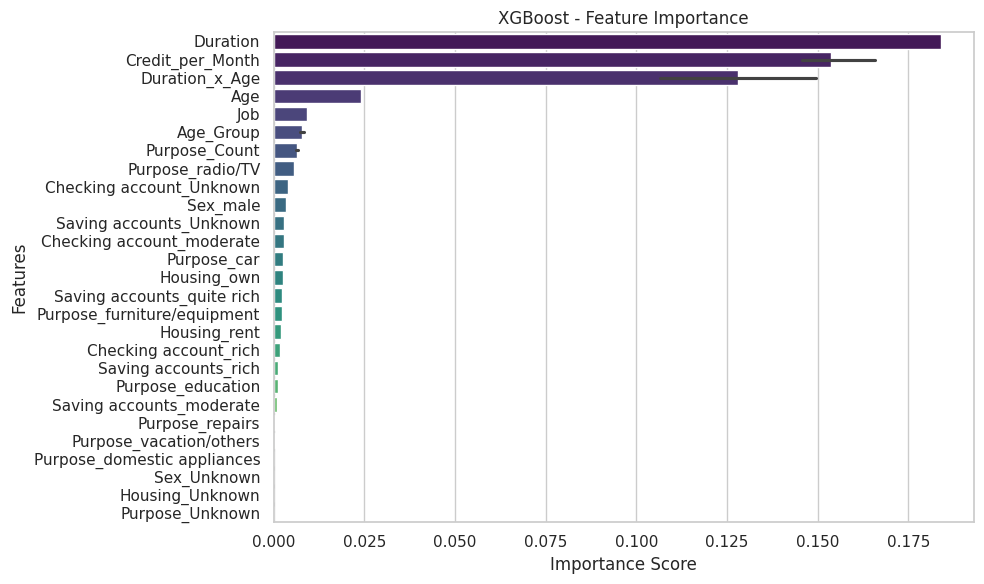

In [29]:

xgb_importance = best_rf.feature_importances_
xgb_features = pd.Series(xgb_importance, index=X.columns).sort_values(ascending=False)

# Ploting the data in the form of bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_features.values, y=xgb_features.index, palette='viridis')
plt.title('XGBoost - Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


### lOGISTIC REGRESSION

In [30]:
from sklearn.linear_model import LogisticRegression


model_logreg = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

# Training the model
model_logreg.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [31]:
# Predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred_logreg = model_logreg.predict(X_test)

# Evaluate
print("\n📘 Logistic Regression Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Precision:", precision_score(y_test, y_pred_logreg))
print("Recall:", recall_score(y_test, y_pred_logreg))
print("F1 Score:", f1_score(y_test, y_pred_logreg))



📘 Logistic Regression Metrics:
Accuracy: 0.91
Precision: 0.9214285714285714
Recall: 0.8896551724137931
F1 Score: 0.9052631578947369


## **RandomForestClassifier**

In [32]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)

# Training the model
model_rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [33]:

y_pred_rf = model_rf.predict(X_test)

print("\n🌲 Random Forest Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))



🌲 Random Forest Metrics:
Accuracy: 0.9633333333333334
Precision: 0.9466666666666667
Recall: 0.9793103448275862
F1 Score: 0.9627118644067797


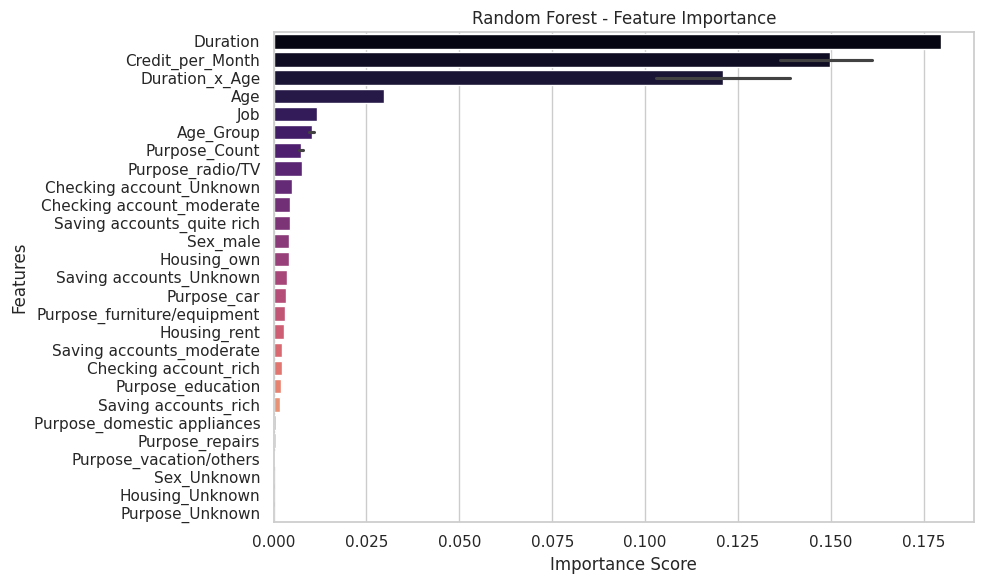

In [34]:
rf_importance = model_rf.feature_importances_
rf_features = pd.Series(rf_importance, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=rf_features.values, y=rf_features.index, palette='magma')
plt.title('Random Forest - Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


COMPARISONS

In [35]:

models = ['XGBoost', 'Logistic Regression', 'Random Forest']
accuracies = [
    accuracy_score(y_test, y_pred),
    accuracy_score(y_test, y_pred_logreg),
    accuracy_score(y_test, y_pred_rf)
]
precisions = [
    precision_score(y_test, y_pred),
    precision_score(y_test, y_pred_logreg),
    precision_score(y_test, y_pred_rf)
]
recalls = [
    recall_score(y_test, y_pred),
    recall_score(y_test, y_pred_logreg),
    recall_score(y_test, y_pred_rf)
]
f1_scores = [
    f1_score(y_test, y_pred),
    f1_score(y_test, y_pred_logreg),
    f1_score(y_test, y_pred_rf)
]


In [22]:
# Creating DataFrame for easier plotting
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})


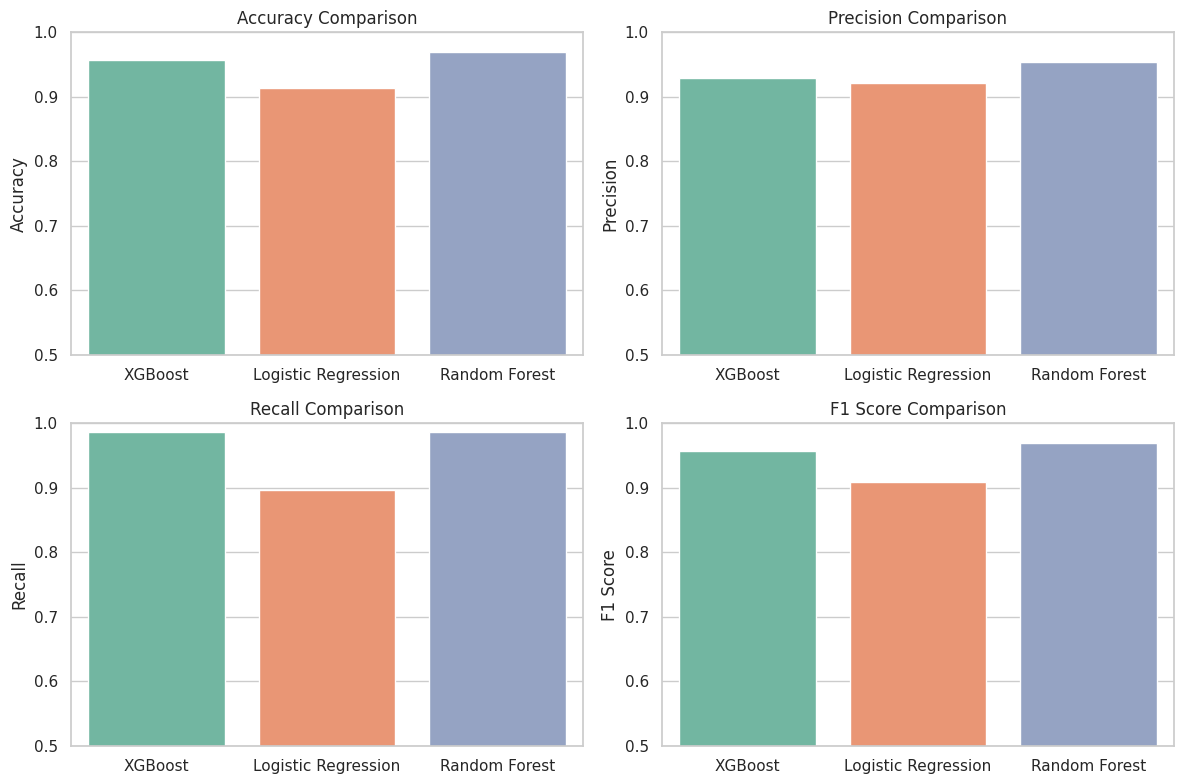

In [36]:

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(data=comparison_df, x='Model', y=metric, palette='Set2')
    plt.title(f'{metric} Comparison')
    plt.ylim(0.5, 1.0)
    plt.ylabel(metric)
    plt.xlabel('')

plt.tight_layout()
plt.show()
